# Курсовая работа
## по курсу "Фундаментальные концепции искусственного интеллекта"

### Выполнил студент группы М8О-114СВ-24 Чистяков Денис

Dataset: [GTSRB (German Traffic Sign Recognition Benchmark)](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)



### Описание датасета
German Traffic Sign Recognition Benchmark (GTSRB) – это датасет, содержащий изображения дорожных знаков, сфотографированных в различных условиях (ракурс, освещение и т.д.). Цель – классифицировать каждый знак в один из 43 заранее определённых классов (например, ограничение скорости, знак «Стоп», приоритет и т.д.)

Основные характеристики датасета:

* Объём: 39 209 изображений в обучающей выборке и 12 630 изображений в тестовой (в исходном варианте). На Kaggle может быть немного другая структура, но общий смысл тот же

* Размеры изображений: чаще всего ~32×32, хотя в реальном датасете картинки могут иметь разную ширину и высоту, и их нужно приводить к одному размеру

* Классы: 43 уникальных типа знаков

* Задача: классификация дорожных знаков

Пример применения – построение системы компьютерного зрения для самоуправляемых автомобилей, которая автоматически определяет дорожные знаки


### Импорт необходимых библиотек и первичная загрузка данных

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.io import read_image

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score
)
from typing import Tuple, List
import warnings

warnings.filterwarnings('ignore')

Структура датасета:

* Train/ – подпапки по номерам классов (от 0 до 42), внутри каждой – изображения соответствующего класса

* Test/ – тестовые картинки с CSV-файлом, в котором указаны ответы

* Meta/ (иногда присутствует) – содержит метаданные


### DataLoader класс для загрузки датасета

In [27]:
class GTSRBDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        
        for class_id in sorted(os.listdir(root_dir)):
            class_folder = os.path.join(root_dir, class_id)
            if os.path.isdir(class_folder):
                for image_name in os.listdir(class_folder):
                    image_path = os.path.join(class_folder, image_name)
                    self.data.append((image_path, int(class_id)))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

Таким образом, при создании GTSRBDataset мы получим объект, позволяющий по одному извлекать образцы изображений и их метки

### Краткая статистика и визуализация данных

Всего изображений в Train: 39209
Распределение по классам (class_id: count):
0: 210
1: 2220
2: 2250
3: 1410
4: 1980
5: 1860
6: 420
7: 1440
8: 1410
9: 1470
10: 2010
11: 1320
12: 2100
13: 2160
14: 780
15: 630
16: 420
17: 1110
18: 1200
19: 210
20: 360
21: 330
22: 390
23: 510
24: 270
25: 1500
26: 600
27: 240
28: 540
29: 270
30: 450
31: 780
32: 240
33: 689
34: 420
35: 1200
36: 390
37: 210
38: 2070
39: 300
40: 360
41: 240
42: 240


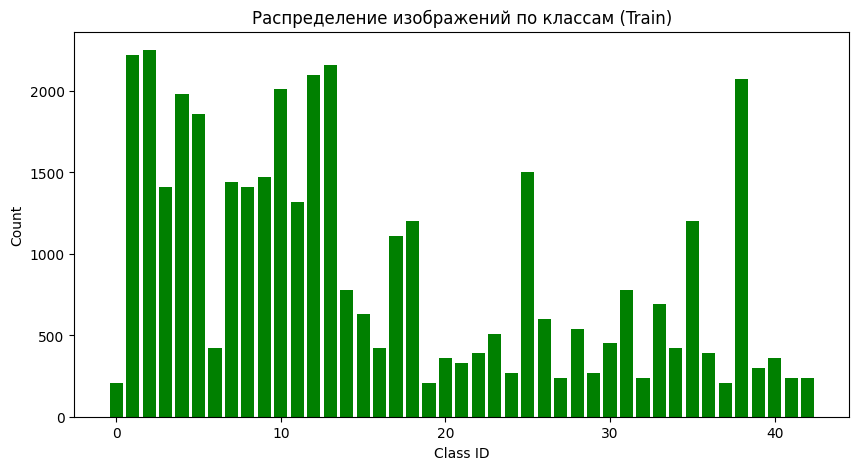

In [28]:
train_root = "GTSRB/Train"
dataset = GTSRBDataset(root_dir=train_root)

print(f"Всего изображений в Train: {len(dataset)}")

class_counts = {}
for _, label in dataset.data:
    class_counts[label] = class_counts.get(label, 0) + 1

print("Распределение по классам (class_id: count):")
for c in sorted(class_counts.keys()):
    print(f"{c}: {class_counts[c]}")

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='green')
plt.title("Распределение изображений по классам (Train)")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()

### Подготовка к обучению

Изображения приводятся к одному размеру, конвертируются в Tensor и нормализуются

In [29]:
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = GTSRBDataset(root_dir=train_root, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

images, labels = next(iter(train_loader))
print(f"Batch shape (images): {images.shape}")
print(f"Batch shape (labels): {labels.shape}")

Batch shape (images): torch.Size([32, 3, 32, 32])
Batch shape (labels): torch.Size([32])


### Создание и обучение модели

Для классификации дорожных знаков используем CNN в PyTorch

In [30]:
class TrafficSignClassifier(nn.Module):
    def __init__(self, num_classes=43):
        super(TrafficSignClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrafficSignClassifier(num_classes=43).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Цикл обучения

In [31]:
num_epochs = 10
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_running_loss / len(val_loader)
    val_acc = 100.0 * val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch [1/10] Train Loss: 1.8114, Train Acc: 45.82% | Val Loss: 0.4819, Val Acc: 86.76%
Epoch [2/10] Train Loss: 0.4102, Train Acc: 86.80% | Val Loss: 0.1131, Val Acc: 96.33%
Epoch [3/10] Train Loss: 0.1906, Train Acc: 94.11% | Val Loss: 0.0722, Val Acc: 97.64%
Epoch [4/10] Train Loss: 0.1241, Train Acc: 96.06% | Val Loss: 0.0401, Val Acc: 98.71%
Epoch [5/10] Train Loss: 0.0931, Train Acc: 97.15% | Val Loss: 0.0329, Val Acc: 98.81%
Epoch [6/10] Train Loss: 0.0781, Train Acc: 97.48% | Val Loss: 0.0417, Val Acc: 98.79%
Epoch [7/10] Train Loss: 0.0639, Train Acc: 98.00% | Val Loss: 0.0384, Val Acc: 98.89%
Epoch [8/10] Train Loss: 0.0594, Train Acc: 98.12% | Val Loss: 0.0373, Val Acc: 99.06%
Epoch [9/10] Train Loss: 0.0509, Train Acc: 98.44% | Val Loss: 0.0261, Val Acc: 99.23%
Epoch [10/10] Train Loss: 0.0463, Train Acc: 98.63% | Val Loss: 0.0256, Val Acc: 99.13%


Графики обучения

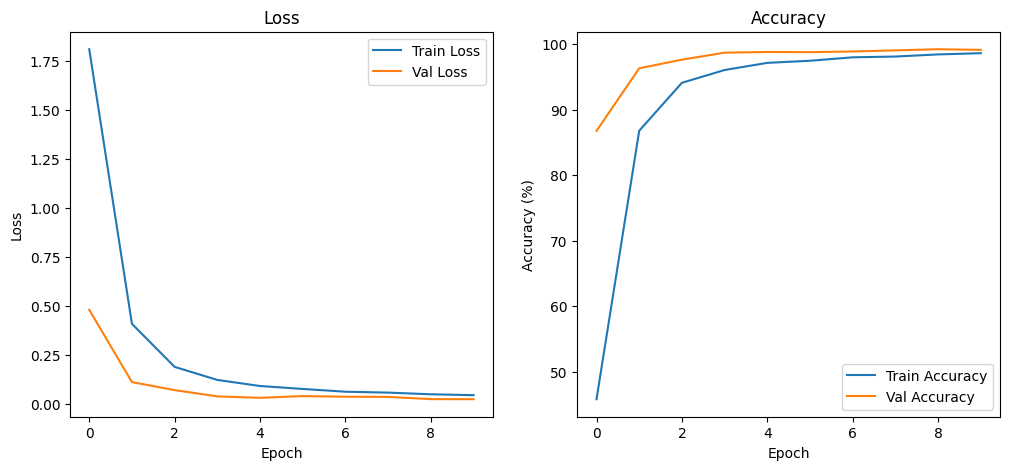

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()

### Проверка на тестовых данных

In [33]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image

class GTSRBDatasetCSV(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        img_name = os.path.join(self.root_dir, row["Path"])
        image = Image.open(img_name).convert('RGB')
        label = int(row["ClassId"])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

Batch 0, size 32
Batch 1, size 32
Batch 2, size 32
Batch 3, size 32
Batch 4, size 32
Batch 5, size 32
Batch 6, size 32
Batch 7, size 32
Batch 8, size 32
Batch 9, size 32
Batch 10, size 32
Batch 11, size 32
Batch 12, size 32
Batch 13, size 32
Batch 14, size 32
Batch 15, size 32
Batch 16, size 32
Batch 17, size 32
Batch 18, size 32
Batch 19, size 32
Batch 20, size 32
Batch 21, size 32
Batch 22, size 32
Batch 23, size 32
Batch 24, size 32
Batch 25, size 32
Batch 26, size 32
Batch 27, size 32
Batch 28, size 32
Batch 29, size 32
Batch 30, size 32
Batch 31, size 32
Batch 32, size 32
Batch 33, size 32
Batch 34, size 32
Batch 35, size 32
Batch 36, size 32
Batch 37, size 32
Batch 38, size 32
Batch 39, size 32
Batch 40, size 32
Batch 41, size 32
Batch 42, size 32
Batch 43, size 32
Batch 44, size 32
Batch 45, size 32
Batch 46, size 32
Batch 47, size 32
Batch 48, size 32
Batch 49, size 32
Batch 50, size 32
Batch 51, size 32
Batch 52, size 32
Batch 53, size 32
Batch 54, size 32
Batch 55, size 32
Ba

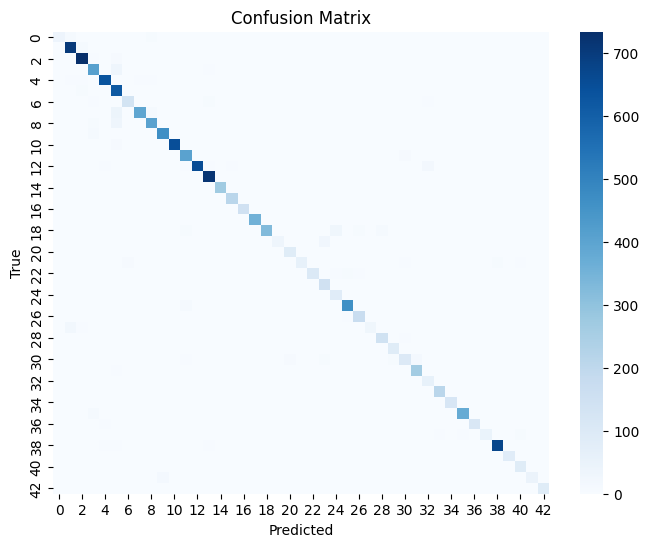

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        60
           1       0.94      0.98      0.96       720
           2       0.96      0.98      0.97       750
           3       0.91      0.92      0.91       450
           4       0.98      0.96      0.97       660
           5       0.81      0.98      0.89       630
           6       0.91      0.89      0.90       150
           7       0.98      0.88      0.92       450
           8       0.94      0.90      0.92       450
           9       0.96      0.97      0.96       480
          10       1.00      0.98      0.99       660
          11       0.93      0.96      0.95       420
          12       0.99      0.95      0.97       690
          13       0.97      1.00      0.98       720
          14       1.00      1.00      1.00       270
          15       0.97      1.00      0.99       210
          16       1.00      0.99      0.99       150
    

In [34]:
test_csv = "GTSRB/Test.csv"
test_root = "GTSRB"

test_dataset = GTSRBDatasetCSV(
    csv_file=test_csv,
    root_dir=test_root,
    transform=test_transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        print(f"Batch {batch_idx}, size {images.size(0)}")
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Точность на тестовой выборке: {acc*100:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds))

### Понижение размерности

Можно вытянуть из модели фичи из последнего перед классификатором слоя, и применить PCA, чтобы визуально показать распределение данных в 2D или 3D пространстве

Возьмём финальные фичи (размерность 12844=2048)

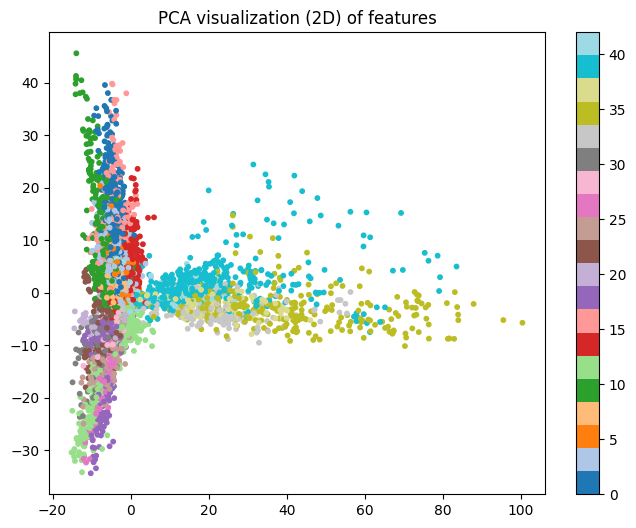

In [35]:
model.eval()
features_list = []
labels_list = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        feats = model.features(images)
        feats = feats.view(feats.size(0), -1)
        features_list.append(feats.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

features_array = np.concatenate(features_list, axis=0)
labels_array = np.array(labels_list)

pca = PCA(n_components=2)
reduced = pca.fit_transform(features_array)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels_array, cmap='tab20', s=10)
plt.colorbar()
plt.title("PCA visualization (2D) of features")
plt.show()

### Кластеризация

Проведем кластеризацию полученных признаков методом K-Means, чтобы посмотреть, будут ли объекты группироваться по классам

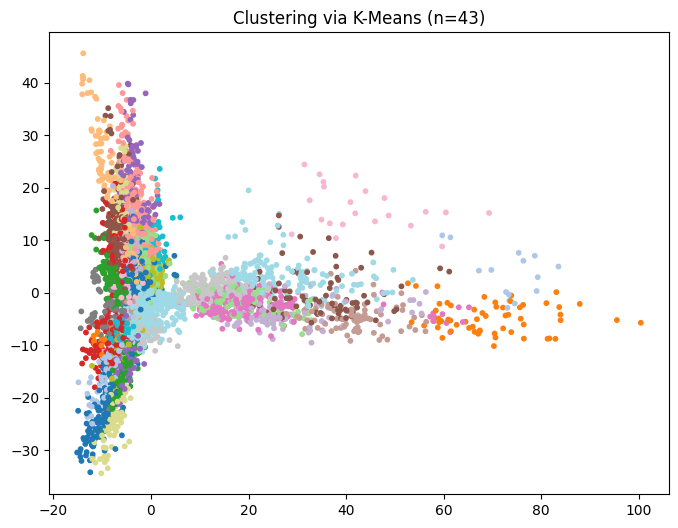

In [36]:
kmeans = KMeans(n_clusters=43, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=kmeans_labels, cmap='tab20', s=10)
plt.title("Clustering via K-Means (n=43)")
plt.show()

Кластеризация без учителя даёт не очень чёткие результаты, но демонстрирует возможность группировки объектов

### Поиск выбросов

Для поиска выбросов можно взять те же фичи, что и для кластеризации, и применить LOF:

In [37]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
outlier_labels = lof.fit_predict(features_array)

num_outliers = sum(outlier_labels == -1)
print(f"Найдено выбросов: {num_outliers}")

Найдено выбросов: 79


### ML Systems Design

CNN для распознавания дорожных знаков в продакшене может выглядеть так:

1. Источник данных: видеопоток с камеры автомобиля

2. Предобработка: кадры видео обрабатываются, выделяются участки дорожных знаков (либо моделью Object Detection, либо более простым алгоритмом)

3. Классификатор (наша модель): полученный «кроп» дорожного знака отправляется в модель PyTorch/ONNX/TensorRT, которая выдаёт класс знака

4. Логика принятия решений: в зависимости от распознанного знака (например, «Stop», «Speed Limit 60», «Priority Road») система адаптирует поведение автомобиля или предупреждает водителя

Преимущества:

* Снижает нагрузку на водителя (или даёт основу для самоуправляемого транспорта)

* Высокая скорость обработки (CNN хорошо оптимизируются на GPU/TPU)

* Хорошая точность на стандартных дорожных знаках

Недостатки:

* Может давать сбои при плохом освещении, заслонённых или повреждённых знаках

* Требует регулярного обновления и проверки качества при смене условий (например, новая камера с иным разрешением)